# Testing `hera_pspec` with EoR and Point-Source Foregrounds

Lily Whitler, Steven Murray, Bobby Pascua, Zachary Martinot, and the HERA Validation Team

## Setup and Metadata

### Abstract

We simulate ideal observations of a sky with a $1/k^2$ EoR power spectrum and a point-source foreground model from GLEAM with `RIMEz`. The EoR part of the sky is the same simulation as used in Step 0.2.0.

We then run a fiducial `hera_pspec` pipeline over the simulation, ensuring that outside the wedge region the power spectrum is unbiased as compared to the known analytic input to the level of 1%. 

### Imports

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
import copy
import glob
import sys
import pathlib
from collections import defaultdict

import astropy
import astropy.units as units
import h5py

import hera_cal
import hera_pspec
import pyuvdata
import uvtools

from pyuvdata import UVData, UVBeam
from hera_cal import io
from hera_pspec.data import DATA_PATH as PSPEC_DATA_PATH

sys.path.append("../../")
import template_tools

### Description

In [2]:
print(f'Last executed: {str(datetime.now())}')

Last executed: 2020-03-18 12:54:55.555516


### Summary

- **Major Step Description:** Simulate visibilities of point-source foregrounds and $1/k^2$ EoR power spectrum. Extract power spectrum estimates with `hera_pspec`.
- **Minor Variation Description:** Use GLEAM to provide foregrounds, simulated by `RIMEz`.
- **Pipelines Tested:** `pspec`
- **Criteria**:
  1. Residuals to known analytic input EoR PS within 1% after incoherent averaging over 8 hours, outside wedge. 
  2. Residuals of EoR+FG, where EoR dominates, should match EoR-only (even with random fluctuations), proving that FG have no broad effect outside their regime.

### Software

In [5]:
template_tools.print_dep_versions(extras=['astropy', 'hera_cal'], ignore=['healvis'])

Module pyuvdata   ....	Version 1.5.0  .......	Git 
Module hera_stats ....	Version 1.5.0  .......	Git 


/users/smurray/miniconda3/envs/validation/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/users/smurray/miniconda3/envs/validation/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/users/smurray/miniconda3/envs/validation/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/users/smurray/miniconda3/envs/validation/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additi

Module hera_sim   ....	Version 0.3.0  .......	Git b"b'3c7818556a8c84049d6c153a01c58deed317e831'"
Module hera_qm    ....	Version 1.0    .......	Git 393ee1add2bd582b1142f5f5a85ef33664383382
Module hera_pspec ....	Version 0.2.0  .......	Git dad85a51adb57501dc24081cd7ea9687cf512e7c
Module linsolve   ....	Version 0.0.1  .......	Git 
Module uvtools    ....	Version 0.1.0  .......	Git c9fbb3f9fe5697b86f5f768a8593c660f4c3c6df
Module numpy      ....	Version 1.18.1 .......	Git None
Module healpy     ....	Version 1.12.9 .......	Git None
Module h5py       ....	Version 2.9.0  .......	Git None
Module astropy    ....	Version 4.0    .......	Git None
Module hera_cal   ....	Version 3.0    .......	Git cc3bf17bddbdcef76cc3c95ea63cf7c810402080


### Data

The following paths reflect the exact locations of all data used in this test:

In [14]:
# Root directory where all the simulated data lives
root_path = pathlib.Path("/lustre/aoc/projects/hera/Validation/")
data_path = root_path / 'test-1.1.0'

# data_prefix = "hera_hex37_100-200MHz_HERA_dipole_"
vis_path = data_path / "visibilities"
spec_path = data_path / "spectra"
plot_path = data_path / "plots"

# Path to beam normalization data
omegas_data_path = root_path / 'HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
assert omegas_data_path.exists()

The following paths point to the original simulation files used to create the data for this notebook, but are never read directly here.

In [7]:
data_prefix = 'hera_hex37_100-200MHz_HERA_dipole_'

eor_path = os.path.join(root_path, data_prefix + 'beam_pow_neg2_pspec/realization_0.uvh5')
gleam_path = os.path.join(root_path, data_prefix + 'full_gleam_plus_brights_v01/' +
                          'hera_hex37_full_gleam_plus_brights_v01.uvh5')

print("Base EOR Simulation: ", eor_path)
print("Base GLEAM Simulation: ", gleam_path)

Base EOR Simulation:  /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.uvh5
Base GLEAM Simulation:  /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_full_gleam_plus_brights_v01/hera_hex37_full_gleam_plus_brights_v01.uvh5


## Extra Utility Functions

In [8]:
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hera_pspec.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                         Om_b=Om_b,
                                                         Om_c=Om_c,
                                                         H0=H0,)
    return hps_cosmo

In [9]:
# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_data(vis_data_path, flag_nchan_low=50, flag_nchan_high=50):
    # choose only data that hasn't been flagged, assuming 1024 frequency channels
    chans = np.arange(1024)[flag_nchan_low:-flag_nchan_high]
    
    uvd = UVData()
    uvd.read_uvh5(vis_data_path, freq_chans=chans, keep_all_metadata=False)
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]
    
    VI_data = uvd.data_array[:,:,:,xx_ind] + uvd.data_array[:,:,:,yy_ind]
    
    uvd.select(polarizations=(-5))
    uvd.polarization_array[0] = 1
    uvd.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd

In [15]:
def plot_spectra(uvp_avgs, labels, blps, spws=[0], polpair=('pI', 'pI'),
                 fig=None, ax=None, linestyles=None, linewidths=None,
                 colors=None, alpha=0.5, figsize=(10, 7)):
    
    # Expects a list of averaged uvps and the label/name of each
    assert len(uvp_avgs) == len(labels)
    
    # Set up defaults for plotting
    if linestyles is None:
        linestyles = ['-'] * len(uvp_avgs)
    if linewidths is None:
        linewidths = [3.5] * len(uvp_avgs)
    if colors is None:
        colors = ['k'] * len(uvp_avgs)
    
    ax_arg = True
    if ax is None:
        fig, ax = plt.subplots(len(blps), len(spws), sharex='col', sharey='row', figsize=figsize)
        ax_arg = False
        
    for i in range(len(blps)):
        for j in range(len(spws)):
            key = (spws[j], blps[i], polpair)
            freq_range = uvp_avgs[0].get_spw_ranges(spws[j])[0][:2]
            
            k_paras = uvp_avgs[0].get_kparas(spws[j])
            analytic_spectrum = get_analytic_spectrum(uvp_avgs[0], spws[j])            
                                   
            # Set up for plotting
            # Deal with cases when there is only one subplot, one spw, or one baseline pair
            # First make sure that if there was an axis passed, we use it
            if ax_arg:
                ax_plot = ax
            # Otherwise, deal with the cases of only having one subplot, one row, and/or one column
            else:
                if len(fig.get_axes()) == 1:
                    ax_plot = ax
                elif len(blps) == 1:
                    ax_plot = ax[j]
                elif len(spws) == 1:
                    ax_plot = ax[i]
                else:
                    ax_plot = ax[i, j]
            
            # Actually plot the spectra
            ax_plot.loglog(k_paras, np.abs(analytic_spectrum), ls=':', lw=2, color='#3F3F3F',
                           alpha=0.75, label='Analytic EoR')
            for k in range(len(uvp_avgs)):
                uvp_plot = uvp_avgs[k].get_data(key)
                ax_plot.loglog(k_paras, np.abs(uvp_plot[0]), ls=linestyles[k], lw=linewidths[k],
                               color=colors[k], alpha=alpha, label=labels[k])

            ax_plot.set_xlabel(r'$k_\parallel$ [$h$ Mpc$^{-1}$]', fontsize=16)
            ax_plot.set_ylabel(r'Power [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=16)
            ax_plot.set_title('spw: {:0.0f} - {:0.0f} MHz; '.format(freq_range[0] / 1e6, freq_range[1] / 1e6) +
                              'blp: {}; pol: {}'.format(key[1], key[2]), fontsize=14)
            ax_plot.legend(fontsize=12)

In [16]:
def get_pspec(pspec_file):
    psc = hera_pspec.container.PSpecContainer(pspec_file, keep_open=False)
    uvp = psc.get_pspec(psc.groups()[0])[0]
    return uvp

In [17]:
def get_k_nyquist(uvp, spw=0):
    keys = uvp.get_all_keys()
    dly = uvp.get_dlys(spw)
    
    if dly.size % 2 == 0:
        tau_nyquist = np.amax(dly)
    else:
        ddly = np.diff(dly)[0]
        tau_nyquist = np.amax(dly) + ddly/2.

    spw_freqs = uvp.freq_array[uvp.spw_freq_array == spw]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))

    return np.amax(tau_nyquist)*uvp.cosmo.tau_to_kpara(z_mean, little_h=True)

def aliased_power_spectrum(k, k_nyquist, z, freq_dep=False):
    A0 = 1e1 * (1./0.2)**-2.
    Pk = 1e6 * A0 * (np.pi)**2. * 1./(2. * k_nyquist * np.sin(np.pi*k /(2*k_nyquist)))**2
    
    if freq_dep:
        # assume we're working with the power spectrum w/ frequency-scaled amplitude
        # so follow the steps in the 0.2.0 notebook
        
        # frequency of HI line at the source
        f21_emit = 1420.4057517667 # MHz
        
        # redshifted 21-cm line
        f21_obs = f21_emit/(1 + z)
        
        # scale the power spectrum by an overall factor of 100 at 100 MHz
        # also put in the freq scaling
        Pk *= 100 * (100 / f21_obs)**6
        
    return Pk * cosmo.h / (1 + z)**2

def get_analytic_spectrum(uvp, spw, freq_dep=False):
    # Get redshift of band center for scaling the aliased spectrum
    freq_range = uvp.get_spw_ranges(spw)[0][:2]
    center = (freq_range[0] + freq_range[1]) / 2
    z = 1420405751.7667 / center - 1
    k_paras = uvp.get_kparas(spw)
    k_nyquist = get_k_nyquist(uvp, spw=spw)
    
    return aliased_power_spectrum(k_paras, k_nyquist, z, freq_dep)

## Single File Test

Initially, we want to test the pipeline on a small amount of data to get the feel for what is happening and to make sure the pipeline works. To do this, we run the script referenced below on the full simulations, splitting up the visibilities into smaller chunks of time that can be read in separately. We use the first such chunk in this section. 

In [18]:
print(f"Data created with {data_path / 'prepare_data.py'}")

Data created with /lustre/aoc/projects/hera/Validation/test-1.1.0/prepare_data.py


### Data Reading

In [20]:
single_eor_path = pathlib.Path(sorted(glob.glob(str(vis_path / 'zen.*.RR.eor.uvh5')))[0])
single_fg_path = pathlib.Path(str(single_eor_path).replace("eor", "foregrounds"))
single_sum_path = pathlib.Path(str(single_eor_path).replace("eor", "true"))
print(single_eor_path)
print(single_fg_path)
print(single_sum_path)

/lustre/aoc/projects/hera/Validation/test-1.1.0/visibilities/zen.2451545.16100.RR.eor.uvh5
/lustre/aoc/projects/hera/Validation/test-1.1.0/visibilities/zen.2451545.16100.RR.foregrounds.uvh5
/lustre/aoc/projects/hera/Validation/test-1.1.0/visibilities/zen.2451545.16100.RR.true.uvh5


Now let's read in the data as `hera_cal.HERAData` objects: 

In [21]:
data_single = {label: {} for label in ['eor', 'fg', 'sum']}
vis_single_files = [single_eor_path, single_fg_path, single_sum_path]

for label, pth in zip(data_single.keys(), vis_single_files):    
    data_single[label]['vis'] = io.HERAData(str(pth))
    data_single[label]['vis'].read(return_data=False)

Telescope RIMEz calculation is not in known_telescopes.


In [22]:
times = np.unique(data_single['eor']['vis'].time_array)
lsts = np.unique(data_single['eor']['vis'].lst_array)
freqs = np.unique(data_single['eor']['vis'].freq_array)

### Power Spectra

In this section, we inspect the power spectrum estimates for the "single file" set of data.

In [23]:
# define the cosmology
cosmo = astropyPlanck15_for_hera_pspec()

# choose only the unflagged frequencies (all should be unflagged since we did nothing with hera_cal, xrfi, etc.)
freq_slice = slice(None)

# load beam-dependent normalization data
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'][()][freq_slice]
    Omegapp = h5f['Omegapp'][()][freq_slice]

beam = hera_pspec.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, freqs[freq_slice], cosmo=cosmo)

# wrapper for pspec_run
def calc_pspec(vis_file, outfile, spw_ranges=None, blpairs=None):
    uvdI = get_VI_data(str(vis_file))
    hera_pspec.pspecdata.pspec_run(
        [uvdI], str(outfile), dset_pairs=[(0, 0)], file_type="uvh5",
        taper="blackman-harris", beam=beam, cosmo=cosmo,
        spw_ranges=spw_ranges, blpairs=blpairs, pol_pairs=[('pI','pI')],
        Jy2mK=True, exclude_cross_bls=True, 
        overwrite=True, verbose=True
    )

In [24]:
spec_single_files = [str(v).replace(".uvh5", ".psc") for v in vis_single_files]

spws = [(400, 600)]
blps = [((32, 0), (32, 0))]

In [25]:
%%time
for vis_file, pspec_file in zip(vis_single_files, spec_single_files):
    print("Extracting spectrum from {}".format(vis_file.name))
    calc_pspec(vis_file, pspec_file, spws, blps)

Extracting spectrum from zen.2451545.16100.RR.eor.uvh5
Opening /lustre/aoc/projects/hera/Validation/test-1.1.0/visibilities/zen.2451545.16100.RR.eor.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((32, 0), (32, 0))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...
Storing dset0_x_dset0
Extracting spectrum from zen.2451545.16100.RR.foregrounds.uvh5
Opening /lustre/aoc/projects/hera/Validation/test-1.1.0/visibilities/zen.2451545.16100.RR.foregrounds.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((32, 0), (32, 0))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...
Storing dset0_x_dset0
Extracting spectrum from zen.2451545.16100.RR.true.uvh5
Opening /lustre/aoc/projects/hera/Validation/test-1.1.0/visibilities/zen.2

In [26]:
# Now read in the power spectra from the files we just made, and average them over time.
for fl, key in zip(spec_single_files, data_single.keys()):
    data_single[key]['ps'] = get_pspec(str(fl))
    blpair_group = [[blp] for blp in np.unique(data_single[key]['ps'].blpair_array)]
    data_single[key]['avg'] = data_single[key]['ps'].average_spectra(
        blpair_groups=blpair_group, time_avg=True, inplace=False
    )
    data_single[key]['avg'].fold_spectra()

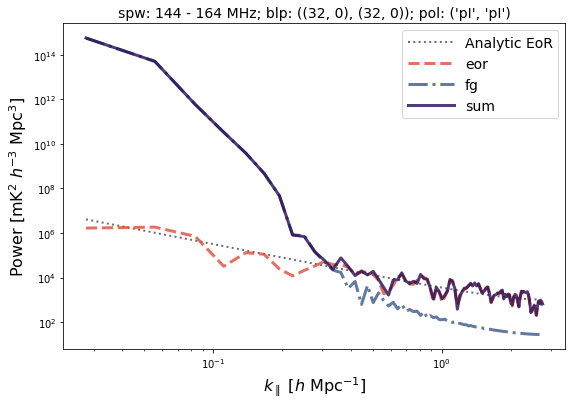

In [27]:
labels = list(data_single.keys())
colors = ['#DA4E3B', '#3D5789', '#270B52']
linewidths, linestyles = [3, 3, 3], ['--', '-.', '-']
uvp_avgs = [val['avg'] for val in data_single.values()]
plot_spectra(
    uvp_avgs, labels, 
    blps, 
    colors=colors, 
    linestyles=linestyles,         
    linewidths=linewidths, 
    alpha=0.8, 
    figsize=(9, 6)
)

fig = plt.gcf()
ax = fig.get_axes()
fig.subplots_adjust(hspace=0.2)
ax[0].legend(loc='upper right', fontsize=14, handlelength=3.25);



**Figure 1** | Power spectrum estimates from various visibility data sets for a "single file" worth of data (66 integrations). The EoR dominates the foregrounds above about k∼0.5Mpc/h. 

## Full Day Results

In this section, we examine the resulting power spectra from performing the above analysis on a data set spanning 8 hours. Python scripts for all of the data preparation and analysis can be found in the data_path as defined above (see the scripts with _multiprocessing in their names for power spectrum retrieval; see the preparation scripts in the master_data subdirectory to see how the raw simulation files were modified to work with a modified version of the pipeline's makeflow; see the scripts in the makeflow subdirectory to see how the makeflow for this test was configured). A brief summary of the test steps is as follows:

Visibilities were simulated for 24 hours over the full HERA H1C bandwidth (100 MHz - 200 MHz) over 1024 frequency channels with a uniform integration time of 10.7 seconds. Two sets of visibilities were simulated: one component is for point-source foregrounds, simulated using the GLEAM diffuse sky model; the other component is for the EoR signal, with a power spectrum amplitude that goes like $P(k)=A_0 k^{−2}$ each visibility component contains simulated observations for four polarizations (XX, XY, YX, YY). The simulations were carried out with the RIMEz simulation package, using the HERA dipole beam model. The individual visibility files were added together to form the "true" sky model, but only the first eight hours of the simulated data were used for this test. Finally, note that the visibility simulations are noiseless and perfectly calibrated.

The power spectrum estimates were obtained using the ``pspec_run`` function in the hera_pspec.pspecdata module, exactly as defined in the "Single-File Test" section. This test used four spectral windows over the bandwidth 120-180 MHz and a Blackman-Harris taper for calculating the power spectrum estimates. We present the results on a per-spectral-window basis, showing both a scatter plot of power spectrum estimates on a per-baseline basis, as well as a line plot that has been averaged over all baselines. Each power spectrum presented has been incoherently averaged over the full eight hours. 

### Power Spectrum Results 

In this section, we load and visualize the power spectrum estimations for every data set for the full eight hours investigated in this test. 

In [28]:
paths = {key: sorted(glob.glob(str(spec_path / f"*.RR.{kind}.psc"))) for key, kind in zip(['eor', 'fg', 'sum'], ['eor', 'foregrounds', 'true'])}

Let's check how many power spectra we have on disk for each kind: 

In [29]:
for path_list in paths.values():
    print(len(path_list))

122
122
122


Set up a dictionary to house the spectra for all spectral windows: 

In [31]:
spectra = {}

In [34]:
%%time
# incoherently average all the spectra
# each spw has 154 channels, but we'll be folding the spectra

for label, path in paths.items():
    for pth in path:
        
        uvp = get_pspec(pth)
        uvp.fold_spectra()
        
        if label not in spectra:
            spectra[label] = {spw: defaultdict(list) for spw in uvp.spw_array}
            
        for key in uvp.get_all_keys():
            spw = key[0]
            blp = key[1]
            spectra[label][spw][blp].append(uvp.get_data(key))

CPU times: user 43.3 s, sys: 30.6 s, total: 1min 13s
Wall time: 4min 19s


In [35]:
spw_edges = [(spw[0], spw[1]) for spw in uvp.get_spw_ranges()]
k_paras = [uvp.get_kparas(j) for j in range(len(spw_edges))]
dlys = [uvp.get_dlys(j) for j in range(len(spw_edges))]

In [36]:
# the spectra dictionaries should have 6 spws, and each spw should have Nblp dictionaries
# each dictionary spectra[spec_file][spw][blp] should have a list with length Nfiles
# each entry in the list should have shape (66, 99) corredsponding to (Ntimes, Nkpara)

spectra_avg = {}
for label, spec_dict in spectra.items():
    spectra_avg[label] = {}
    
    for spw, spec_by_spw in spec_dict.items():
        spectra_avg[label][spw] = {}
        
        bl_avg = 0
        for blp, spec in spec_by_spw.items():
            # assert all(s.shape == (66, 99) for s in spec)

            # Reshape the spectra so we can do an easier average.
            # New arrays have the shape (Nfiles*Ntimes, Nkpara)
            spec = np.array(spec)
            spec_by_spw[blp] = spec.reshape((-1, spec.shape[-1]))
            
            spectra_avg[label][spw][blp] = np.mean(spec_by_spw[blp], axis=0)
            bl_avg += spectra_avg[label][spw][blp]
            
        spectra_avg[label][spw]['average'] = bl_avg / len(spec_dict[0])

In [37]:
Nkinds = len(spectra)
Nspws  = len(spectra['eor'])
Nblps  = len(spectra['eor'][0])

In [38]:
# now get the expected power spectrum for each spectral window
aliased_spectra = {spw: get_analytic_spectrum(uvp, spw) for spw in uvp.spw_array}

In [39]:
def plot_avg_spectra(spectra_avg, analytic, resid=False, xlim=None, ylim=None):
    # for now, let's only plot the abscal, smoothed abscal, simple cal, and true power spectra
    colors = ['#DA4E3B', '#3D5789', '#270B52']
    alphas = (0.5, 0.6, 0.6)

    linestyles = ('-', ':', '--', '-', '-', '-')
    lws = (4, 4, 4, 6, 6, 6)

    # bundle these up into a tuple of things to be iterated over
    plot_iterator = lambda : zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws)

    # create a figure and axes objects
    fig = plt.figure(figsize=(15, 5.8 * Nspws))
    axes = fig.subplots(Nspws)

    # setup stuff
    for j in range(Nspws):
        ax = axes[j]
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        ax.grid(b=True, which="major", axis="y")
        ax.grid(b=True, which="both", axis="x")
        fmin, fmax = spw_edges[j]
        ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                      "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                      fontsize=12)

        ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
        
        
        ax.set_xscale('log')
        if not resid:
            ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
            ax.set_yscale('log')
        else:
            ax.set_ylabel(r"Fractional Residual Power", fontsize=12)
            
    # plot all the ("measured") things    
    for spw, kparallel in enumerate(k_paras):
        ax = axes[spw]
        
        for (label, spec), color, alpha, ls, lw in zip(spectra_avg.items(), colors, alphas, linestyles, lws):
            
            if resid:
                ax.plot(kparallel, (np.abs(spec[spw]['average']) - analytic[spw])/analytic[spw], lw=lw, ls=ls, color=color, alpha=alpha, label=label)
                ax.axhline(0, lw=2, color='k')
            else:
                ax.plot(kparallel, np.abs(spec[spw]['average']), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
        if not resid:
            ax.plot(kparallel, analytic[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
            
        ax.legend(ncol=2)

        

    plt.tight_layout()

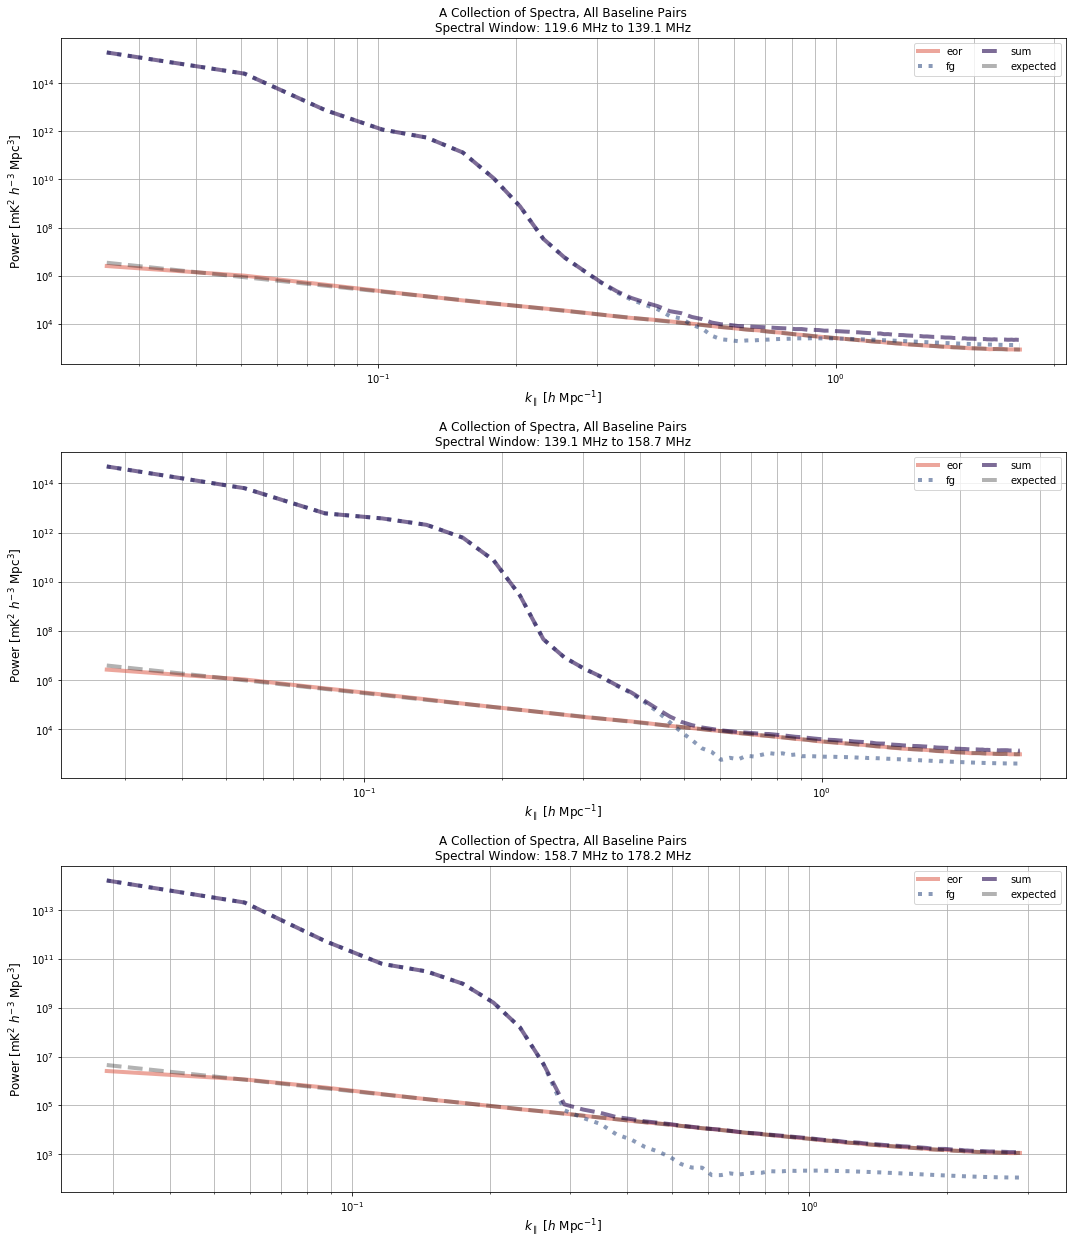

In [41]:
plot_avg_spectra(spectra_avg, aliased_spectra);

**Figure 2** | Power spectra for the three spectral windows used in this analysis. Only auto-baseline pairs were used for power spectrum estimation. Each line notes the power spectrum estimate, incoherently averaged in time over the full eight hours of simulated data used and averaged over all baseline pairs. We only see EoR dominate the signal at some $k$-modes in the upper spectral window. 

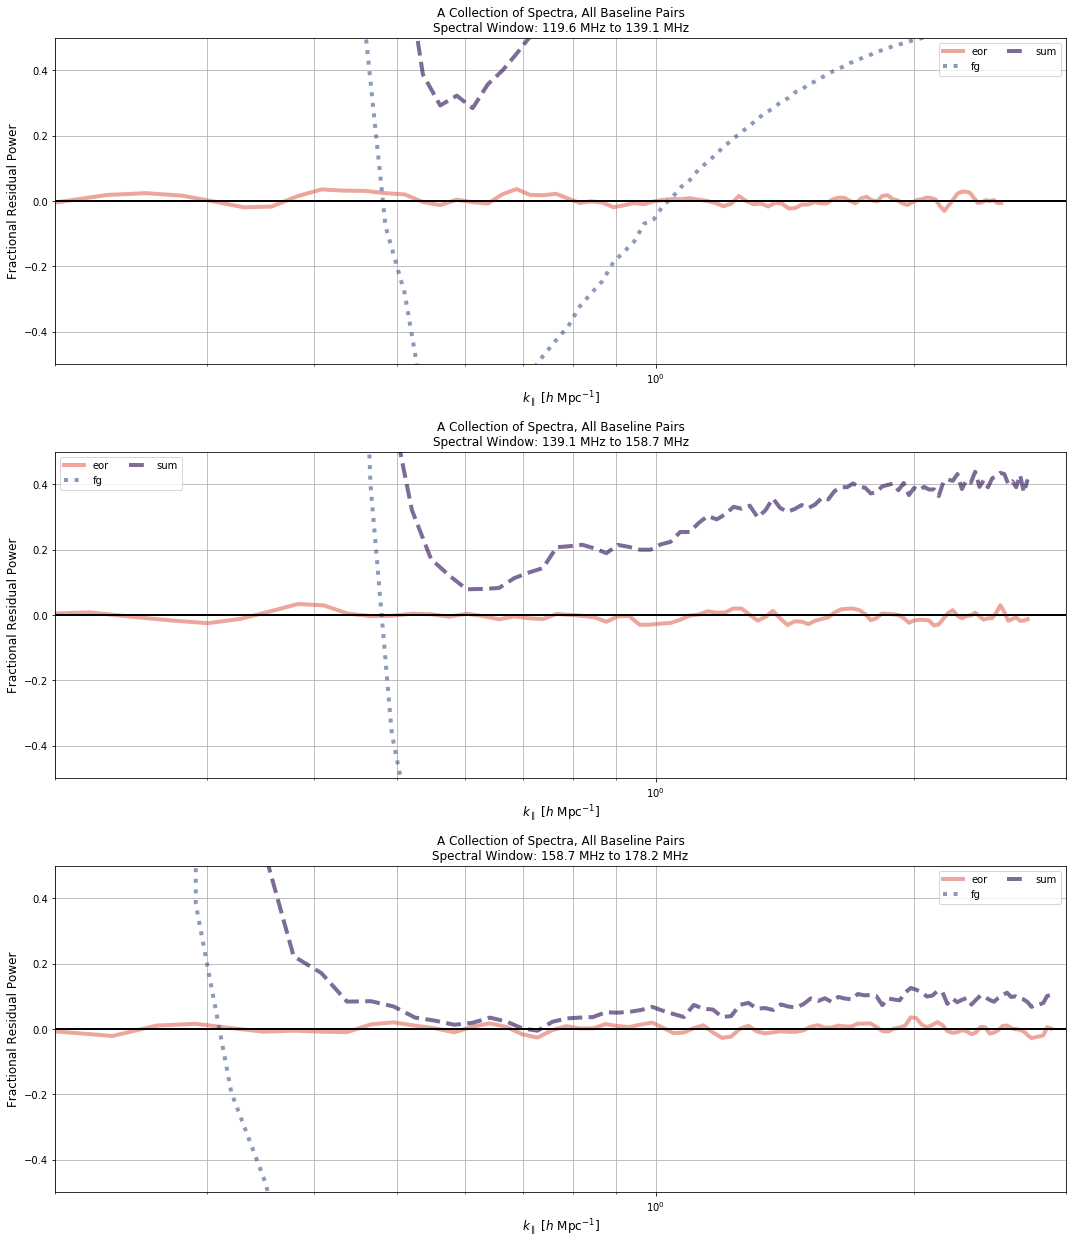

In [42]:
# Plot residual
plot_avg_spectra(spectra_avg, aliased_spectra, resid=True, xlim=(0.2, 3), ylim=(-0.5, 0.5))

**Figure 3** | Fractional residuals, measured relative to the analytic power spectrum. Note that at low frequencies, the EoR is too weak to be detected at any $k_{||}$. At higher frequencies, the estimate of the spectrum of the sum conforms both to the analytic power and the eor power (i.e. foreground power is not being thrown out to arbitrarily high $k_{||}$). 

## Frequency-Dependent EoR Amplitude

In the previous section, we found issues regarding the extraction of the expected EoR signal, likely due to issues regarding windowing and the difference in dynamic range of EoR and foregrounds. In this section, we perform the same analysis as in the previous section, but with an amplified, frequency-dependent EoR signal.

In [43]:
# Root directory where all the simulated data lives
fdep_data_path = data_path / 'freq_dep_eor'

# data_prefix = "hera_hex37_100-200MHz_HERA_dipole_"
fdep_vis_path = fdep_data_path / "visibilities"
fdep_spec_path = fdep_data_path / "spectra"

In [44]:
fdep_spec_path

PosixPath('/lustre/aoc/projects/hera/Validation/test-1.1.0/freq_dep_eor/spectra')

In [45]:
fdep_paths = {key: sorted(glob.glob(str(fdep_spec_path / f"*.RR.{kind}.psc"))) for key, kind in zip(['eor', 'fg', 'sum'], ['eor', 'foregrounds', 'true'])}

In [46]:
fdep_spectra = {}

In [47]:
%%time
# incoherently average all the spectra
# each spw has 154 channels, but we'll be folding the spectra

for label, path in fdep_paths.items():
    for pth in path:
        
        uvp = get_pspec(pth)
        uvp.fold_spectra()
        
        if label not in fdep_spectra:
            fdep_spectra[label] = {spw: defaultdict(list) for spw in uvp.spw_array}
            
        for key in uvp.get_all_keys():
            spw = key[0]
            blp = key[1]
            fdep_spectra[label][spw][blp].append(uvp.get_data(key))

CPU times: user 43.9 s, sys: 30.2 s, total: 1min 14s
Wall time: 4min 13s


In [48]:
fdep_spectra_avg = {}
for label, spec_dict in fdep_spectra.items():
    fdep_spectra_avg[label] = {}
    
    for spw, spec_by_spw in spec_dict.items():
        fdep_spectra_avg[label][spw] = {}
        
        bl_avg = 0
        for blp, spec in spec_by_spw.items():
            # assert all(s.shape == (66, 99) for s in spec)

            # Reshape the spectra so we can do an easier average.
            # New arrays have the shape (Nfiles*Ntimes, Nkpara)
            spec = np.array(spec)
            spec_by_spw[blp] = spec.reshape((-1, spec.shape[-1]))
            
            fdep_spectra_avg[label][spw][blp] = np.mean(spec_by_spw[blp], axis=0)
            bl_avg += fdep_spectra_avg[label][spw][blp]
            
        fdep_spectra_avg[label][spw]['average'] = bl_avg / len(spec_dict[0])

In [49]:
fdep_aliased_spectra = {spw: get_analytic_spectrum(uvp, spw, freq_dep=True) for spw in uvp.spw_array}

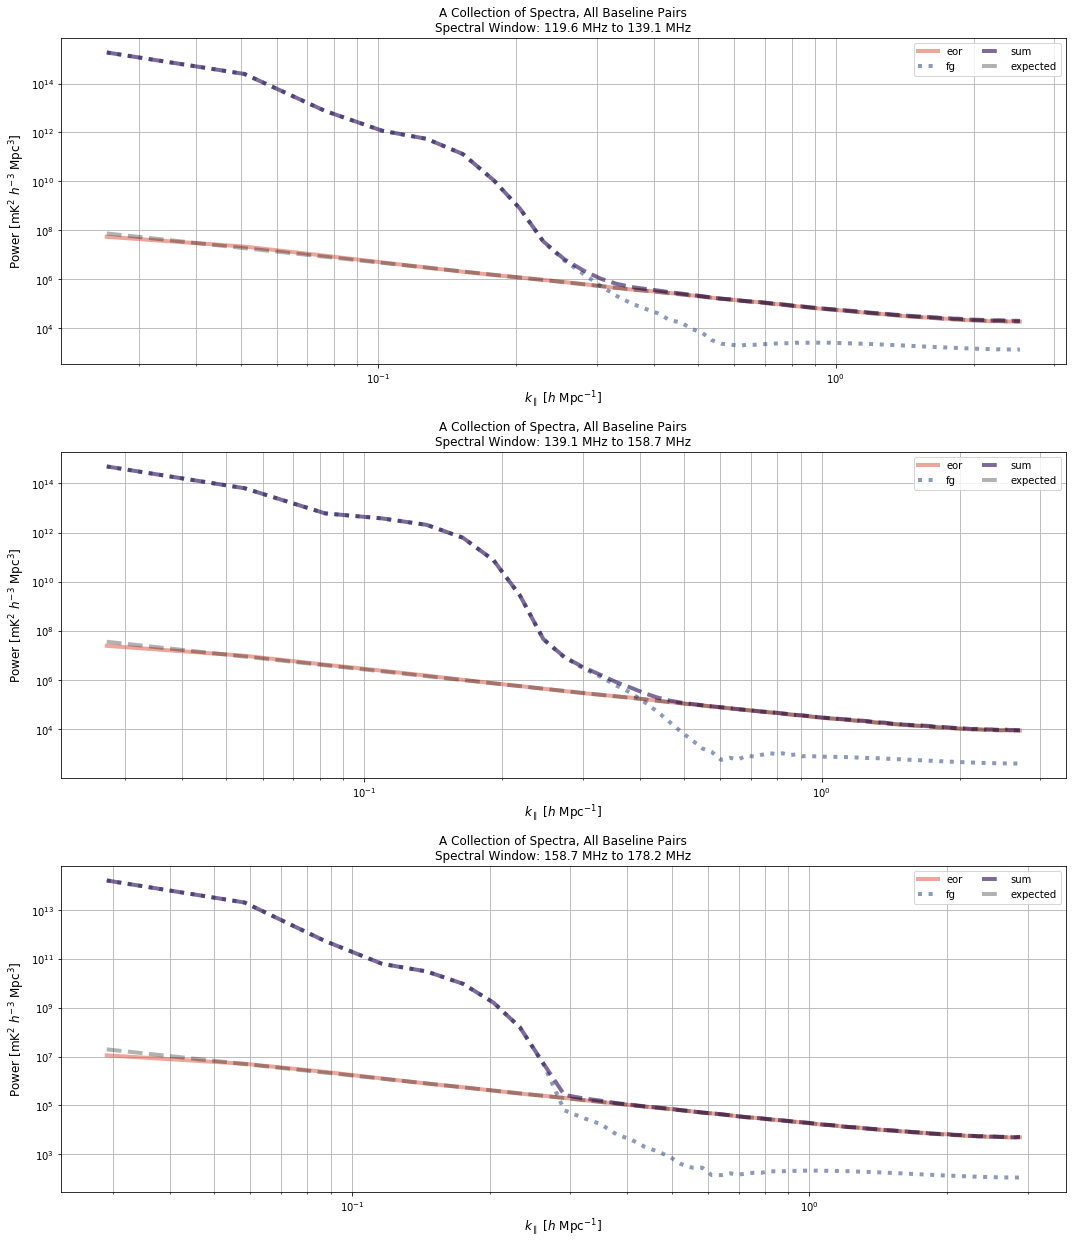

In [50]:
plot_avg_spectra(fdep_spectra_avg, fdep_aliased_spectra);

**Figure 4** | Same as Figure 2, but with an amplified, frequency-dependent EoR spectrum. Note that the EoR is detected without signal loss in each spectral window. 

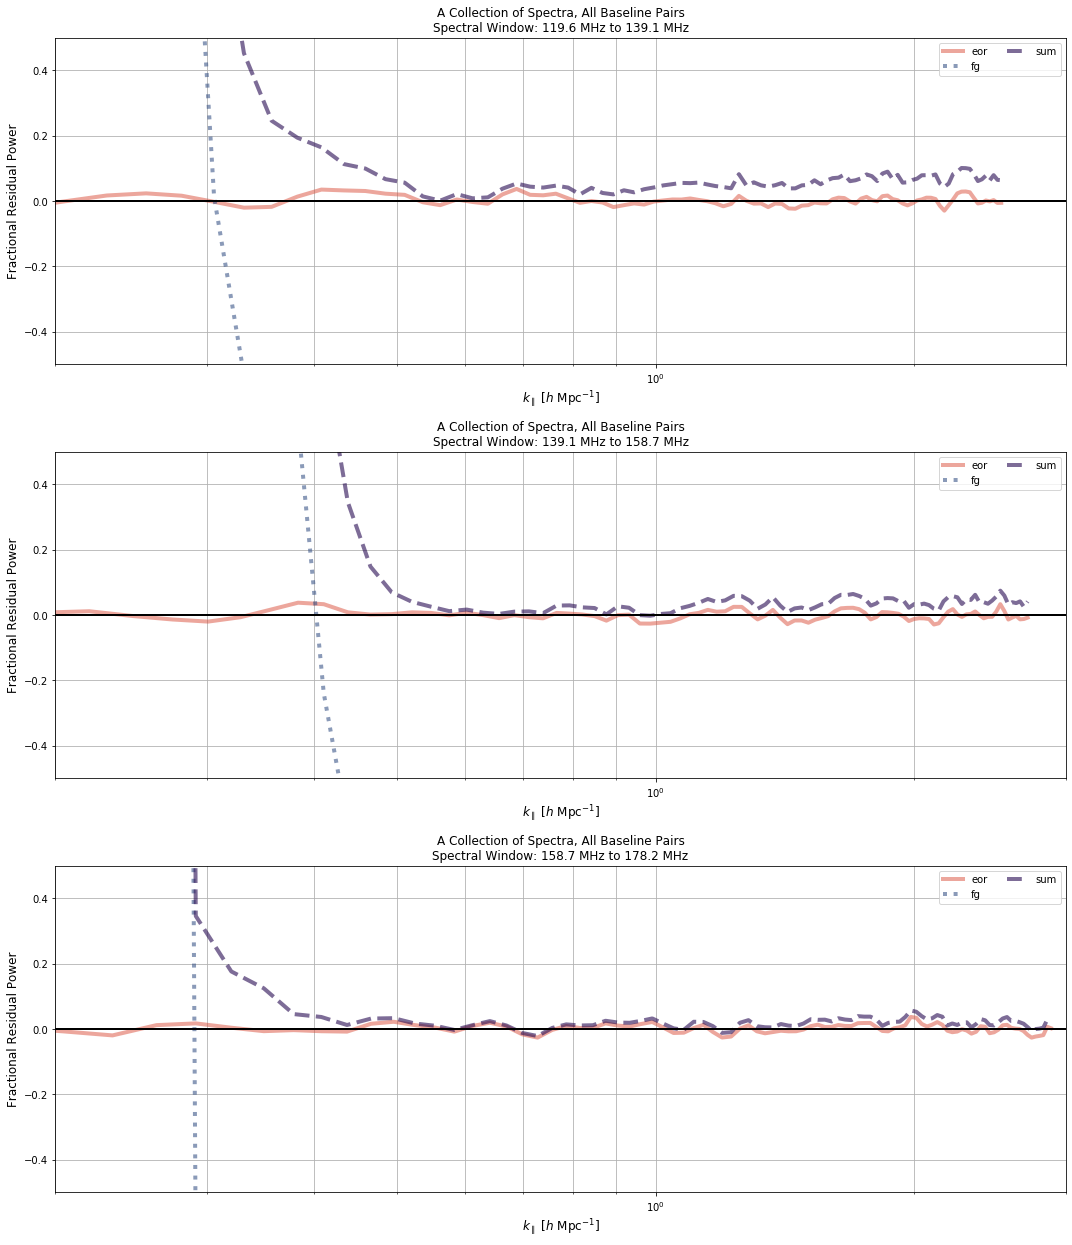

In [51]:
plot_avg_spectra(fdep_spectra_avg, fdep_aliased_spectra, resid=True, xlim=(0.2, 3), ylim=(-0.5, 0.5))

**Figure 5** | Residuals of averaged spectra compared to analytic expectation. Since the EoR variability is boosted by a factor of 100, the residuals are expectedly 100x noisier. In any case, they are well within 20%, and seemingly without bias. 